### AudioSignalProcessing
- Примеры извлечения фич из аудио сигнала (mfcc и пр.)
- Примеры сетей разного типа (CNN, RNN, перцептрон и пр.) для распознования аудио сигнала на тестовых данных
- Подготовить модель распознавания ключевых фраз + other

In [31]:
from os.path import join, isdir, isfile
import os
import shutil
from tqdm.auto import tqdm
import librosa
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import soundcard as sc
import python_speech_features
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [122]:
# Подготовка данных и сохранение в вайл
# Используются записи ключевых слов длительностью 1 секунда,
# сложенные в дирректории, названные в соответствии со словами, содержащимися в них.

# На выходе получаем следующие данные:
# {
#     'mapping':['five', 'no', 'yes',...],
#     'labels':[0,0,0,... 1,1,1,... 2,2,2,...],
#     'MFCCs':[no_of_sample, time_steps, mfcc_koefficient],
#     'files':['.\\VoiceSamples\\YesNoFive10Samples\\five\\004ae714_nohash_0.wav',...]
# }

#######################################################################################
# Define variables here
#######################################################################################

downloads = r".\VoiceSamples"

input_voice_samples_folders = join(downloads, 'YesNoFive10Samples')
# input_voice_samples_folders = join(downloads, 'OnOffUpDownStopOthers250Samples')

output_voice_features_json = join(input_voice_samples_folders, "data.json")
output_trained_model = join(input_voice_samples_folders, "model.h5")

sample_length = 22050 # 1 sec. of audio

#######################################################################################

#######################################################################################

def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """
    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {"mapping": [], "labels": [], "MFCCs": [], "files": []}
    
    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we're at sub-folder level
        if dirpath is not dataset_path:
            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("\\")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))
            # process all audio files in sub-dir and store MFCCs
            for file in tqdm(filenames):
                file_path = join(dirpath, file)
                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)
                # drop audio files with less than pre-decided number of samples
                if len(signal) >= sample_length:
                    # ensure consistency of the length of the signal
                    signal = signal[:sample_length]
                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T[..., np.newaxis].tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    mapping = data['mapping']
    return X, y, mapping

preprocess_dataset(input_voice_samples_folders, output_voice_features_json)

print('\nCompleted')

# На основе:
# The Sound of AI, Deep Learning (Audio) Application: From Design to Deployment, Preparing the Speech Dataset, https://www.youtube.com/watch?v=VPJ2jazh_KI&list=PL-wATfeyAMNpCRQkKgtOZU_ykXc63oyzp&index=2
# GitHub с кодом:
# https://github.com/musikalkemist/Deep-Learning-Audio-Application-From-Design-to-Deployment/tree/master/2-%20Preparing%20the%20Dataset


Completed


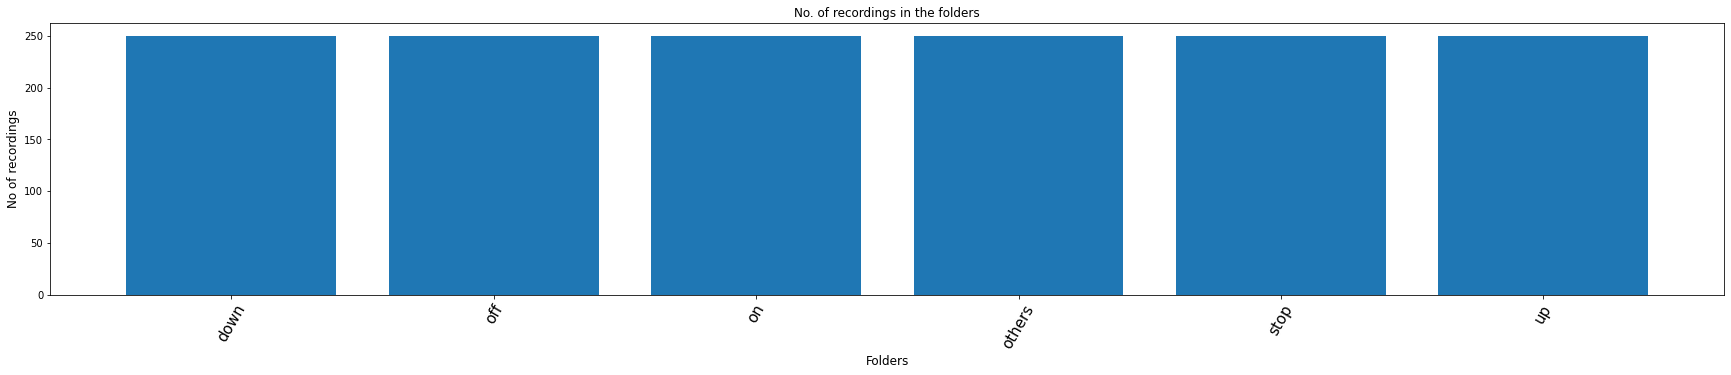

In [61]:
# Проверить кол-во аудиосэмплов каждой фразы

# Folder names with audio samples
labels = [folder for folder in os.listdir(input_voice_samples_folders) 
          if isdir(join(input_voice_samples_folders, folder))]

# Find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# Plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Folders', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings in the folders')
plt.show()

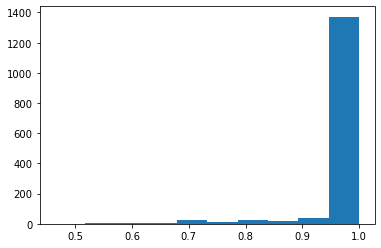

In [62]:
# Проверить длительность сэмплов (в секундах)

duration_of_recordings=[]

for label in labels:
    waves = [file for file in os.listdir(join(input_voice_samples_folders, label)) if file.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(join(input_voice_samples_folders, label, wav))
        duration_of_recordings.append(float(len(samples)/sample_rate))  
plt.hist(np.array(duration_of_recordings))

plt.show()

### Извлечение фич из аудио сигнала

In [13]:
#######################################################################################
# Define variables here
#######################################################################################

sample_file_path = join(downloads, 'SimpleSamples/bird.wav')

#######################################################################################

#######################################################################################

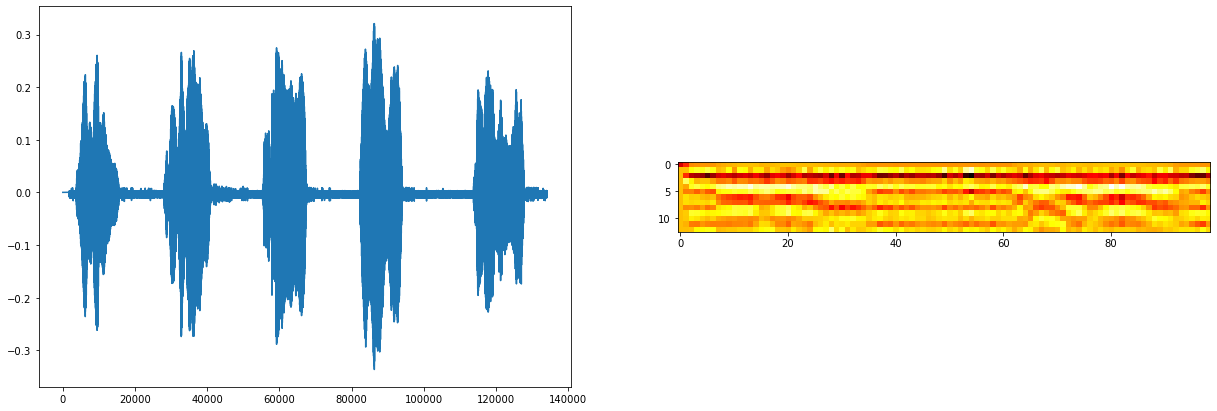

(13, 99)

In [39]:
# Извлечение mfcc с использованием python_speech_features

signal, rate = librosa.load(sample_file_path, sr=44100)

mfcc = python_speech_features.mfcc(signal[:rate], rate, numcep=13, nfilt=13, nfft=1103).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(mfcc, cmap='hot', interpolation='nearest')
plt.show()

mfcc.shape # (13, 44)

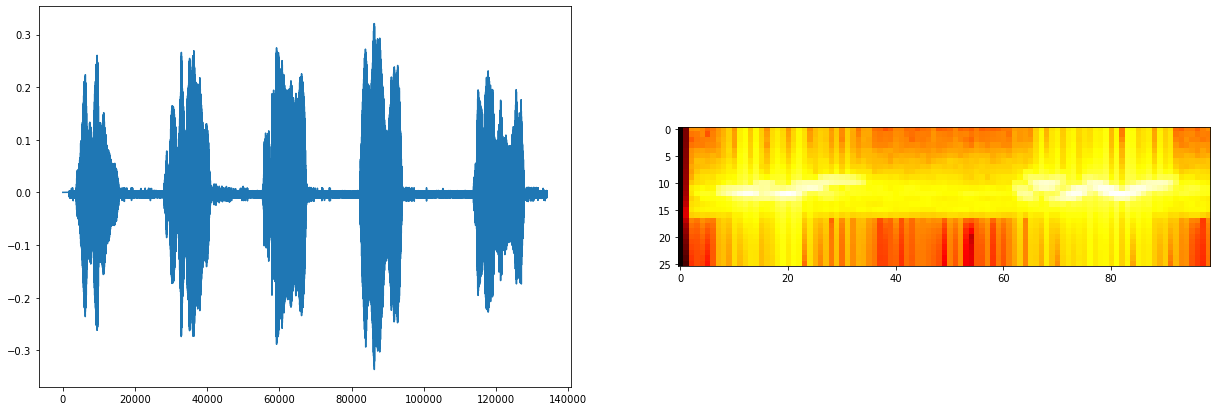

(26, 99)

In [40]:
# Извлечение logfbank с использованием python_speech_features

signal, rate = librosa.load(sample_file_path, sr=44100)

logfbank = python_speech_features.logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(logfbank, cmap='hot', interpolation='nearest')
plt.show()

logfbank.shape # (13, 44)

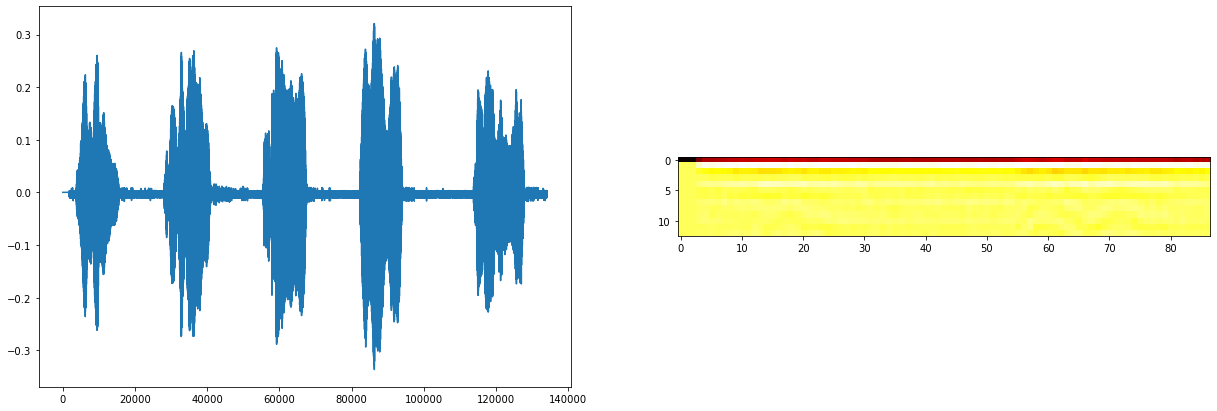

(13, 87)

In [41]:
# Извлечение mfcc в nm.array из wav файла с использованием librosa (ИСПОЛЬЗОВАТЬ)

signal, rate = librosa.load(sample_file_path, sr=44100)

# extract MFCCs
mfcc = librosa.feature.mfcc(signal[:rate], sr=rate, n_mfcc=13, n_fft=1103, hop_length=512)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
axes[0].plot(signal)
axes[1].imshow(mfcc, cmap='hot', interpolation='nearest')
plt.show()

mfcc.shape

### Пример применения CNN

In [74]:
# Подготовка функций

#######################################################################################
# Define variables here
#######################################################################################

downloads = r".\VoiceSamples"

# input_voice_samples_folders = join(downloads, 'DummySamples')
# input_voice_samples_folders = join(downloads, 'YesNoFive10Samples')
input_voice_samples_folders = join(downloads, 'OnOffUpDownStopOthers250Samples')

output_voice_features_json = join(input_voice_samples_folders, "data.json")
output_trained_model = join(input_voice_samples_folders, "model.h5")

EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001
samples_in_class = 250
classes = 6

#######################################################################################

#######################################################################################

# def gen_feat(classes=5, samples_in_class=100, dim=2):
#     """Generates the test dataset as 1 second mfcc audio feature.
#     Input
#         classes (int): the number of the classes to generate.
#         samples_in_class (int): samples in each class.
#         dim (int): 2 or 3 dimensions in the output mfcc data.
#             2 dimentions for 1D convolutional NN
#             3 dimentions for 2D convolutional NN
#     return
#         X (np.ndarray): like 1 second mfcc audio feature
#         y (np.ndarray): classes
#     """
#     X = []
#     y = []
#     for class_ind in range(classes):
#         for _ in range(samples_in_class):
#             X.append(np.array([np.random.normal(loc=class_ind, scale=2, size=13) for _ in range(44)]))
#             y.append(class_ind)
#     if dim == 3:
#         return np.array(X)[..., np.newaxis], np.array(y)
#     elif dim == 2:
#         return np.array(X), np.array(y)

def gen_feat(classes=5, samples_in_class=100, dim=2):
    """Generates the test dataset as 1 second mfcc audio feature.
    Input
        classes (int): the number of the classes to generate.
        samples_in_class (int): samples in each class.
        dim (int): 2 or 3 dimensions in the output mfcc data.
            2 dimentions for 1D convolutional NN
            3 dimentions for 2D convolutional NN
    return
        X (np.ndarray): like 1 second mfcc audio feature
        y (np.ndarray): classes
    """
    X = []
    y = []
    if dim == 3:
        for class_ind in range(classes):
            for _ in range(samples_in_class):
                X.append(np.array([np.random.normal(loc=class_ind, scale=2, size=13) for _ in range(44)]))
                y.append(class_ind)
        return np.array(X)[..., np.newaxis], np.array(y)
    elif dim == 2:
        for class_ind in range(classes):
            for _ in range(samples_in_class):
                X.append(np.random.normal(loc=class_ind, scale=2, size=8000))
                y.append(class_ind)
        return np.array(X)[..., np.newaxis], np.array(y)
    
def prepare_dataset(X, y, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """
    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, y_train, X_validation, y_validation, X_test, y_test

def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001, output_shape=classes):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()
    
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    
    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.5)
    
    # softmax output layer
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])
    
    # print model parameters on console
    model.summary()
    
    return model

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)
    # train model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """
    fig, axs = plt.subplots(2)
    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")
    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")
    plt.show()

##### Применение CNN на dummy
Пример решения задачи классификации с использованием tensorflow CNN. Данные сгенерированы вручную аналогичные данным голоса mfcc.


    X_train:      (800, 44, 13, 1)
    X_validation: (200, 44, 13, 1)
    X_test:       (250, 44, 13, 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_16 (Batc (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 2, 32)         0         
_____________

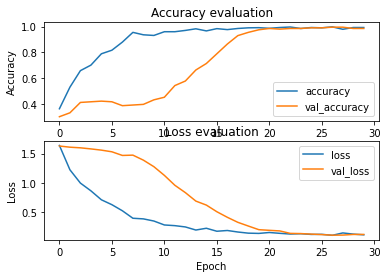

250/250 [==============================] - 0s 228us/sample - loss: 0.1181 - accuracy: 1.0000


In [67]:
# Генерация данных, обучение модели, тестирование и сохранение осученной модели в файл

def main():
    
    # generate dataset
    X, y = gen_feat(classes=5, samples_in_class=samples_in_class, dim=3)
    
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(X, y)

    print(f"""
    X_train: {str(X_train.shape):>21}
    X_validation: {str(X_validation.shape):>15}
    X_test: {str(X_test.shape):>22}\n""")
    
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1) # (segments, coeffisients=13, 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)
    
    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    
    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)
    
    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # save model
    model.save(output_trained_model)

main()

##### Применение CNN на реальных данных
Пример решения задачи классификации с использованием tensorflow CNN. Данные сгенерированы вручную аналогичные данным голоса mfcc.


    X_train:      (855, 44, 13, 1)
    X_validation: (214, 44, 13, 1)
    X_test:       (268, 44, 13, 1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_25 (Batc (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 2, 32)         0         
_____________

855/855 [==============================] - 1s 920us/sample - loss: 0.3243 - accuracy: 0.9696 - val_loss: 0.9661 - val_accuracy: 0.6682
Epoch 43/100
855/855 [==============================] - 1s 952us/sample - loss: 0.3151 - accuracy: 0.9708 - val_loss: 0.9574 - val_accuracy: 0.6776
Epoch 44/100
855/855 [==============================] - 1s 944us/sample - loss: 0.2991 - accuracy: 0.9766 - val_loss: 0.9525 - val_accuracy: 0.6542
Epoch 45/100
855/855 [==============================] - 1s 903us/sample - loss: 0.2947 - accuracy: 0.9708 - val_loss: 0.9526 - val_accuracy: 0.6682
Epoch 46/100
855/855 [==============================] - 1s 978us/sample - loss: 0.2805 - accuracy: 0.9778 - val_loss: 0.9346 - val_accuracy: 0.7009
Epoch 47/100
855/855 [==============================] - 1s 913us/sample - loss: 0.2656 - accuracy: 0.9813 - val_loss: 0.9255 - val_accuracy: 0.7009
Epoch 48/100
855/855 [==============================] - 1s 881us/sample - loss: 0.2689 - accuracy: 0.9789 - val_loss: 0.9462 

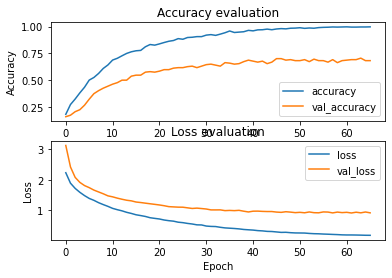

268/268 [==============================] - 0s 205us/sample - loss: 0.9113 - accuracy: 0.7127


In [75]:
# Загрузка данных из файла, обучение модели, тестирование и сохранение осученной модели в файл

def main():
    
    # generate dataset
    X, y, _ = load_data(output_voice_features_json)
    
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(X, y)

    print(f"""
    X_train: {str(X_train.shape):>21}
    X_validation: {str(X_validation.shape):>15}
    X_test: {str(X_test.shape):>22}\n""")
    
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1) # (segments, coeffisients=13, 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)
    
    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    
    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)
    
    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    # save model
    model.save(output_trained_model)

main()

##### Проверки

In [77]:
# Загрузка модели и проверка на повторно сгенерированных данных (для сгенерированных вручную данных)

# Поготовить новые данные
X, y = gen_feat(classes=5, samples_in_class=samples_in_class, dim=3)
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(X, y)

# Загрузить модель из файла
model = tf.keras.models.load_model(output_trained_model)
model.summary()

# Протестировать модель на новых данных
test_loss, test_acc = model.evaluate(X_train, y_train)
print(f"\nTest loss: {round(test_loss, 3)}\nTest accuracy: {round(100*test_acc,2)}%")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_25 (Batc (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 1, 32)         

In [78]:
# Протестировать модель на отдельных данных

index = 101

result = model.predict(X_train)

predicted_result_ind = np.argmax(result[index])
result_ind = y_train[index]

print(f'Predicted: {predicted_result_ind}, Fact: {result_ind}')

Predicted: 5, Fact: 0


##### Предсказания с микрофона

In [130]:
# Предсказание с микрофона (для осученной на реальных данных модели)

samplerate = 22050 # (int) – The desired sampling rate in Hz
sec = 1

numframes = int(samplerate * sec) # (int) – The number of frames to record. Такой же как samplerate, чтобы записать секунду.
default_mic = sc.default_microphone()

# Загрузить модель из файла
model = tf.keras.models.load_model(output_trained_model)

# Загрузить маппинг
_, _, mapping = load_data(output_voice_features_json)
mapping

['down', 'off', 'on', 'others', 'stop', 'up']

In [190]:
print(f'Microphone in use: {default_mic}')
signal = default_mic.record(samplerate = samplerate, numframes = numframes, channels = 1).ravel()

if len(signal) >= sample_length:
    # ensure consistency of the length of the signal
    signal = signal[:sample_length]
    # extract MFCCs
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    # store data for analysed track
    mfcc = mfcc.T[np.newaxis,..., np.newaxis]
    
result = model.predict(mfcc)
predicted_result_ind = np.argmax(result)

print(f'Predicted: {mapping[predicted_result_ind]}')

Microphone in use: <Microphone Микрофон гарнитуры (Plantronics C320-M) (2 channels)>
Predicted: on


### Prepare voice samples folder

In [ ]:
# Prepare voice samples folder

downloads = r".\VoiceSamples"
input_voice_samples_folders = join(downloads, 'speech_commands_v0.01')
new_input_voice_samples_folder = 'OnOffUpDownStopOthers250Samples'
num_samples_to_copy = 250
num_samples_to_copy_others = 10

# Read all folders
folders = [folder for folder in os.listdir(input_voice_samples_folders) if isdir(join(input_voice_samples_folders, folder))]

# Select folders for classification and others
class_folders = ['on', 'off', 'up', 'down', 'stop']
other_folders = [folder for folder in folders if not folder in class_folders and not folder.startswith('_')]

# Create new folders for classification + others
os.makedirs(join(downloads, new_input_voice_samples_folder), exist_ok=True, mode=777)
os.makedirs(join(downloads, new_input_voice_samples_folder, 'others'), exist_ok=True, mode=777)
for class_folder in class_folders:
    os.makedirs(join(downloads, new_input_voice_samples_folder, class_folder), exist_ok=True, mode=777)

# Copy files to folders for classification
for class_folder in tqdm(class_folders):
    files = [file for file in os.listdir(join(input_voice_samples_folders, class_folder))
             if isfile(join(input_voice_samples_folders, class_folder, file))]
    for file in files[:num_samples_to_copy]:
        shutil.copy(join(input_voice_samples_folders, class_folder, file),
                    join(downloads, new_input_voice_samples_folder, class_folder))

# Copy files to others for classification
for class_folder in tqdm(other_folders):
    files = [file for file in os.listdir(join(input_voice_samples_folders, class_folder))
             if isfile(join(input_voice_samples_folders, class_folder, file))]
    for file in files[:num_samples_to_copy_others]:
        shutil.copy(join(input_voice_samples_folders, class_folder, file),
                    join(downloads, new_input_voice_samples_folder, 'others', f'{class_folder}_{file}'))

### Материал
- Seth Adams, Deep Learning for Audio Classification, https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P
- Mel Frequency Cepstral Coefficient (MFCC) tutorial, http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
- sentdex, Neural Networks from Scratch in Python, https://www.youtube.com/playlist?list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
- The Sound of AI, Deep Learning (Audio) Application: From Design to Deployment, https://www.youtube.com/playlist?list=PL-wATfeyAMNpCRQkKgtOZU_ykXc63oyzp

##### Датасеты с наборами слов
1. Google AI Blog, Speech Commands Dataset<br>
"The dataset has 65,000 one-second long utterances of 30 short words, by thousands of different people, contributed by members of the public through the AIY website."<br>
https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html

### Developments